In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Helper functions

In [12]:
def import_sfs(file_list, n_samples):
    n_files = len(file_list)
    mSFS = np.zeros((n_files, n_samples-1))
    jSFS_triu = np.zeros((n_files, n_samples*(n_samples-1)//2))
    
    # Import data from files
    for i, f in enumerate(file_list):
        with open(f) as datafile:
            for line in datafile:
                # Skip header lines
                if line.startswith('#'):
                    continue
                # First two non-header lines contain the marginal and joint SFS
                mSFS[i,:] = np.array(line.split(), dtype=float)
                jSFS_triu[i,:] = np.array(datafile.readline().split())
                break
                
    # Unpack the joint SFS
    jSFS = np.zeros((n_files, n_samples-1, n_samples-1))
    for i in range(n_files):
        jSFS[i,:,:][np.triu_indices(n_samples-1)] = jSFS_triu[i,:]
        # Don't double-count the diagonal values
        jSFS[i,:,:][np.diag_indices(n_samples-1)] /= 2
    # Symmetrize distribution
    jSFS += np.transpose(jSFS, axes=(0,2,1))
    
    # Fold marginal and joint SFS.
    mSFS_fold = (mSFS + mSFS[:,::-1])[:,:n_samples//2]
    jSFS_fold = (jSFS + jSFS[:,::-1,:] + jSFS[:,:,::-1] + jSFS[:,::-1,::-1])[:, :n_samples//2, :n_samples//2]
    # Don't double-count the n/2 = n - n/2 values.
    if n_samples % 2 == 0:
        mSFS_fold[:,-1] /= 2
        jSFS_fold[:,-1,:-1] /= 2
        jSFS_fold[:,:-1,-1] /= 2
        jSFS_fold[:,-1,-1] /= 4

    return mSFS_fold, jSFS_fold

## Useful constants

In [13]:
data_dir = "../simulations/"

In [14]:
n_samples = 100
x = np.arange(1, n_samples//2 + 1) / n_samples
sfs_neut = (1/x + 1/(1-x)) / n_samples
pi_weight = 2*x*(1-x)
print(x)
print(pi_weight)

[ 0.01  0.02  0.03  0.04  0.05  0.06  0.07  0.08  0.09  0.1   0.11  0.12
  0.13  0.14  0.15  0.16  0.17  0.18  0.19  0.2   0.21  0.22  0.23  0.24
  0.25  0.26  0.27  0.28  0.29  0.3   0.31  0.32  0.33  0.34  0.35  0.36
  0.37  0.38  0.39  0.4   0.41  0.42  0.43  0.44  0.45  0.46  0.47  0.48
  0.49  0.5 ]
[ 0.0198  0.0392  0.0582  0.0768  0.095   0.1128  0.1302  0.1472  0.1638
  0.18    0.1958  0.2112  0.2262  0.2408  0.255   0.2688  0.2822  0.2952
  0.3078  0.32    0.3318  0.3432  0.3542  0.3648  0.375   0.3848  0.3942
  0.4032  0.4118  0.42    0.4278  0.4352  0.4422  0.4488  0.455   0.4608
  0.4662  0.4712  0.4758  0.48    0.4838  0.4872  0.4902  0.4928  0.495
  0.4968  0.4982  0.4992  0.4998  0.5   ]


In [15]:
r_list = np.insert(np.logspace(-1,3,13), 0, 0.0)
print(r_list)

[  0.00000000e+00   1.00000000e-01   2.15443469e-01   4.64158883e-01
   1.00000000e+00   2.15443469e+00   4.64158883e+00   1.00000000e+01
   2.15443469e+01   4.64158883e+01   1.00000000e+02   2.15443469e+02
   4.64158883e+02   1.00000000e+03]


## Constant-$N$ Kingman

Import SFS data.

In [16]:
file_list = [data_dir + 'jsfs_a-2.0_r-{}.txt'.format(r) for r in r_list]
mSFS_kingman, jSFS_kingman = import_sfs(file_list, n_samples)

Calculate $\pi(r)$, which should be independent of the recombination rate.

In [17]:
pi_kingman = np.dot(mSFS_kingman, pi_weight)
print(pi_kingman)

[ 1.97984264  1.9797683   1.97754926  1.98272966  1.98210526  1.98166954
  1.98094112  1.9815702   1.97896617  1.9827001   1.98249799  1.98372225
  1.97812777  1.97753019]


Plot the marginal SFS against the theoretical expectation. The SFS should be independent of the recombination rate.

/Users/danielrice/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


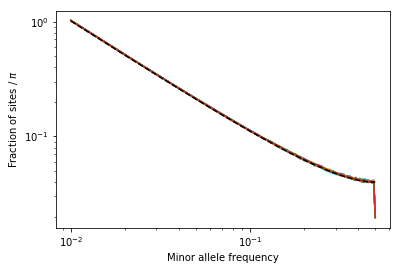

In [18]:
plt.loglog(x, mSFS_kingman.T/pi_kingman[None,:])
plt.loglog(x, sfs_neut, 'k--')
plt.xlabel('Minor allele frequency')
plt.ylabel('Fraction of sites / $\pi$')

Plot the joint SFS of the perfectly-linked case as a heatmap.

/Users/danielrice/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


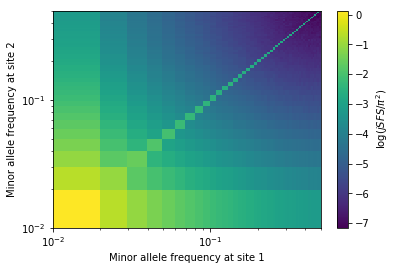

In [19]:
plt.pcolor(x, x, np.log(jSFS_kingman[0,:,:]/pi_kingman[0]**2))
plt.xscale('log')
plt.yscale('log')
plt.colorbar(label='$\log(jSFS/\pi^2)$')
plt.xlabel('Minor allele frequency at site 1')
plt.ylabel('Minor allele frequency at site 2')

Note two trends: Enrichment along the diagonal fall-off with higher frequency. We can eliminate the later by calculating the pointwise mutual information (PMI), which measures enrichment in the joint distribution relative to the product of marginal distributions.

In [21]:
def pmi(mSFS, jSFS):
    mSFS_sq = mSFS[:,None,:] * mSFS[:,:,None]
    return np.log2(jSFS / mSFS_sq)

In [22]:
PMI_kingman = pmi(mSFS_kingman, jSFS_kingman)

/Users/danielrice/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


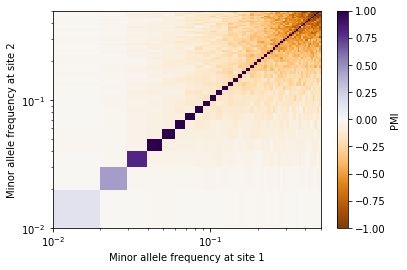

In [99]:
plt.pcolor(x, x, PMI_kingman[0,:,:],
            vmin=-1, vmax=1, cmap='PuOr')
plt.yscale('log')
plt.xscale('log')
plt.colorbar(label='PMI')
plt.xlabel('Minor allele frequency at site 1')
plt.ylabel('Minor allele frequency at site 2')

This clarifies the enrichment along the diagonal and depletion of off-diagonal elements.

How does the pattern change with increasing recombination rate?

/Users/danielrice/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


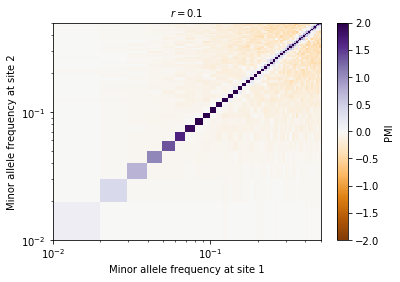

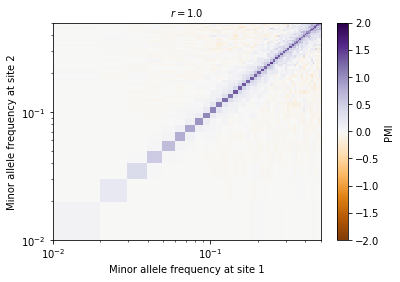

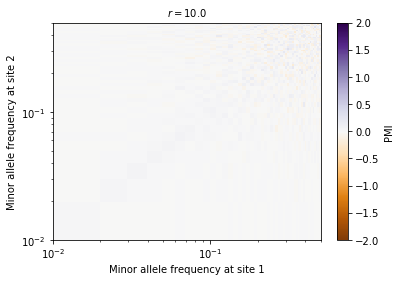

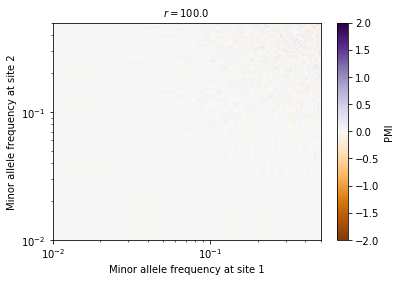

In [24]:
for r in [0.1, 1.0, 10.0, 100.0]:
    i = list(r_list).index(r)
    plt.pcolor(x, x, PMI_kingman[i,:,:],
            vmin=-2, vmax=2, cmap='PuOr')
    plt.yscale('log')
    plt.xscale('log')
    plt.colorbar(label='PMI')
    plt.xlabel('Minor allele frequency at site 1')
    plt.ylabel('Minor allele frequency at site 2')
    plt.title(r'$r = {}$'.format(r))
    plt.show()

The diagonal elements decay to zero. On the other hand, the off-diagonal elements go positive at low, but positive, recombination rate and then decay to zero. The recombination rate scale of this decay is $r=1$.

We can summarize these effects with sums of the diagonal and off-diagonal elements, weighted by the joint distribution as in standard mutual information:

In [25]:
wPMI_kingman = PMI_kingman * jSFS_kingman
diag_kingman = np.sum(np.diagonal(wPMI_kingman, axis1=1, axis2=2), axis=1)
offdiag_kingman = np.sum(wPMI_kingman, axis=(1,2)) - diag_kingman

/Users/danielrice/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


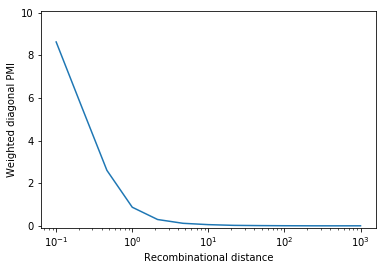

In [29]:
plt.semilogx(r_list, diag_kingman/pi_kingman**2)
plt.ylim([-0.1,10.1])
plt.ylabel('Weighted diagonal PMI')
plt.xlabel('Recombinational distance')

/Users/danielrice/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


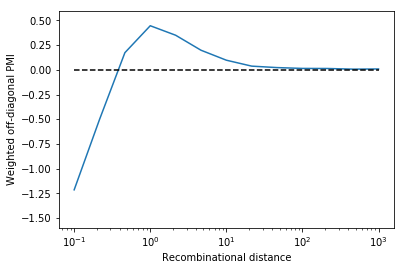

In [30]:
plt.semilogx(r_list, offdiag_kingman/pi_kingman**2)
plt.semilogx(r_list, np.zeros_like(r_list), '--k')
plt.ylim([-1.6,0.6])
plt.ylabel('Weighted off-diagonal PMI')
plt.xlabel('Recombinational distance')

## Beta-coalescents

In [90]:
a_list = [2.0, 1.75, 1.5, 1.25]

mSFS_beta = []
jSFS_beta = []
pi_beta = []
PMI_beta = []
diag_beta = []
offdiag_beta = []
for a in a_list:
    file_list = [data_dir + 'jsfs_a-{}_r-{}.txt'.format(a,r) for r in r_list[:-3]]
    mSFS, jSFS = import_sfs(file_list, n_samples)
    pi = np.dot(mSFS, pi_weight)
    PMI = pmi(mSFS, jSFS)
    wPMI = PMI * jSFS
    diag = np.sum(np.diagonal(wPMI, axis1=1, axis2=2), axis=1)
    offdiag = np.sum(wPMI, axis=(1,2)) - diag
    
    mSFS_beta.append(mSFS)
    jSFS_beta.append(jSFS)
    pi_beta.append(pi)
    PMI_beta.append(PMI)
    diag_beta.append(diag)
    offdiag_beta.append(offdiag)

/Users/danielrice/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


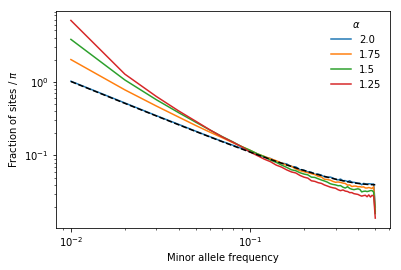

In [32]:
for i,a in enumerate(a_list):
    plt.loglog(x, mSFS_beta[i][0,:]/pi_beta[i][0], label=a)
plt.loglog(x, sfs_neut, 'k--')
plt.xlabel('Minor allele frequency')
plt.ylabel('Fraction of sites / $\pi$')
plt.legend(title=r'$\alpha$')

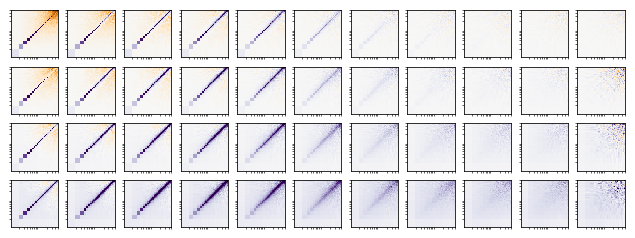

In [33]:
fig = plt.figure(figsize=(11, 4))
for i_a, a in enumerate(a_list):
    for i_r, r in enumerate(r_list[:-3]):
        ax = fig.add_subplot(4, len(r_list)-3, i_a*(len(r_list)-3) + i_r + 1)
        ax.pcolormesh(x, x, PMI_beta[i_a][i_r,:,:],
            vmin=-1, vmax=1, cmap='PuOr')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xticks([])
        ax.set_yticks([])

/Users/danielrice/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


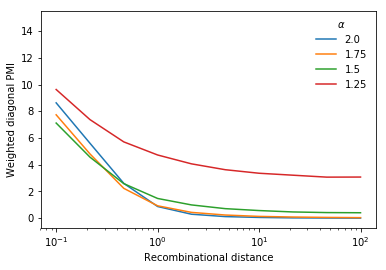

In [34]:
for i,a in enumerate(a_list):
    plt.semilogx(r_list[:-3], diag_beta[i]/pi_beta[i]**2, label=a)
plt.ylabel('Weighted diagonal PMI')
plt.xlabel('Recombinational distance')
plt.legend(title=r'$\alpha$')

/Users/danielrice/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


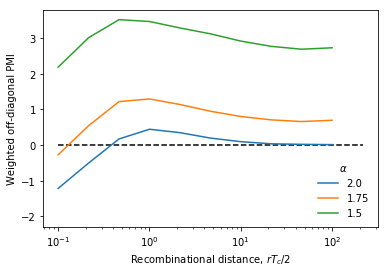

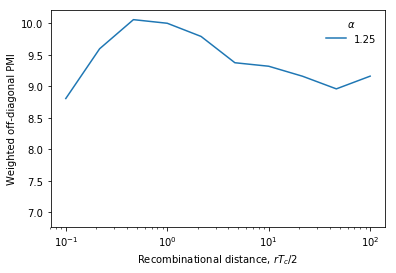

In [51]:
for i,a in enumerate(a_list[:3]):
    plt.semilogx(r_list[:-3], offdiag_beta[i]/pi_beta[i]**2, label=a)
plt.legend(title=r'$\alpha$')
plt.hlines(0, r_list[1], r_list[-3], linestyle='dashed')
plt.ylabel('Weighted off-diagonal PMI')
plt.xlabel('Recombinational distance, $rT_c/2$')
plt.show()

plt.semilogx(r_list[:-3], offdiag_beta[-1]/pi_beta[-1]**2, label='1.25')
plt.legend(title=r'$\alpha$')
plt.ylabel('Weighted off-diagonal PMI')
plt.xlabel('Recombinational distance, $rT_c/2$')

## Exponential growth

In [197]:
g_list = [1.0, 2.0, 4.0, 8.0]

mSFS_exp = []
jSFS_exp = []
pi_exp = []
PMI_exp = []
diag_exp = []
offdiag_exp = []
for g in g_list:
    file_list = [data_dir + 'jsfs_g-{}_r-{}.txt'.format(g,r) for r in r_list[:-3]]
    mSFS, jSFS = import_sfs(file_list, n_samples)
    pi = np.dot(mSFS, pi_weight)
    PMI = pmi(mSFS, jSFS)
    wPMI = PMI * jSFS
    diag = np.sum(np.diagonal(wPMI, axis1=1, axis2=2), axis=1)
    offdiag = np.sum(wPMI, axis=(1,2)) - diag
    
    mSFS_exp.append(mSFS)
    jSFS_exp.append(jSFS)
    pi_exp.append(pi)
    PMI_exp.append(PMI)
    diag_exp.append(diag)
    offdiag_exp.append(offdiag)

[]

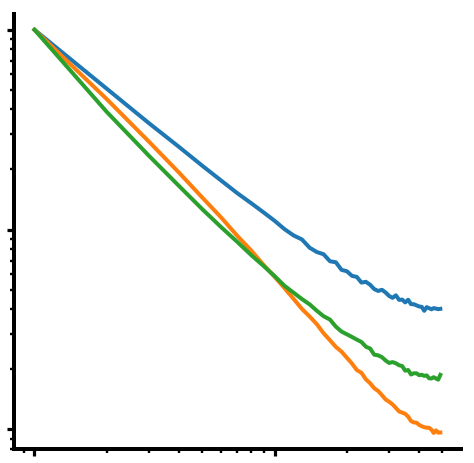

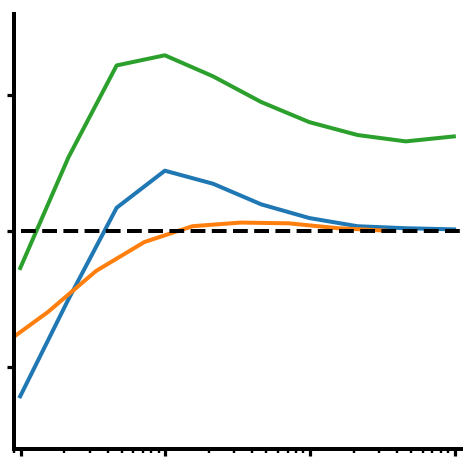

In [198]:
import matplotlib as mpl
lw = 4

mpl.rcParams['axes.linewidth'] = lw
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['xtick.major.width'] = 3.2
mpl.rcParams['xtick.minor.width'] = 2.4
mpl.rcParams['ytick.major.width'] = 3.2
mpl.rcParams['ytick.minor.width'] = 2.4
mpl.rcParams['xtick.major.size'] = 7
mpl.rcParams['xtick.minor.size'] = 4
mpl.rcParams['ytick.major.size'] = 7
mpl.rcParams['ytick.minor.size'] = 4



plt.figure(figsize=(8,8))
ax = plt.subplot(111)
plt.loglog(x[:-1], mSFS_beta[0][0,:-1]/mSFS_beta[0][0,0], lw=lw)
plt.loglog(x[:-1], mSFS_exp[2][0,:-1]/mSFS_exp[2][0,0], lw=lw)
plt.loglog(x[:-1], mSFS_beta[1][0,:-1]/mSFS_beta[1][0,0], lw=lw)
plt.ylim([8e-3, 1.2])
ax.set_yticklabels([])
ax.set_xticklabels([])

plt.figure(figsize=(8,8))
ax = plt.subplot(111)
plt.semilogx(r_list[:-3]*pi_beta[0]/2, offdiag_beta[0]/pi_beta[0]**2, lw=lw)
plt.semilogx(r_list[:-3]*pi_exp[2]/2, offdiag_exp[2]/pi_exp[2]**2, lw=lw)
plt.semilogx(r_list[:-3]*pi_beta[1]/2, offdiag_beta[1]/pi_beta[1]**2, lw=lw)
plt.hlines(0, r_list[1], r_list[-3], linestyle='dashed', lw=lw, zorder=3)
plt.yticks([-1,0,1])
plt.ylim([-1.6,1.6])
plt.xlim([0.09,110])
ax.set_yticklabels([])
ax.set_xticklabels([])



[  0.00000000e+00   1.00000000e-01   2.15443469e-01   4.64158883e-01
   1.00000000e+00   2.15443469e+00   4.64158883e+00   1.00000000e+01
   2.15443469e+01   4.64158883e+01   1.00000000e+02   2.15443469e+02
   4.64158883e+02   1.00000000e+03]
[ 1.97984264  1.9797683   1.97754926  1.98272966  1.98210526  1.98166954
  1.98094112  1.9815702   1.97896617  1.9827001   1.98249799]
[ 1.9812246   1.97844118  1.98283893  1.97901912  1.98820122  1.9755378
  1.97770564  1.97817148  1.98183064  1.97612384  1.98991442]
[  0.00000000e+00   6.63353828e-02   1.42945957e-01   3.07957795e-01
   6.63434081e-01   1.43036637e+00   3.07900760e+00   6.63688754e+00
   1.42984372e+01   3.07856011e+01   6.64177920e+01]
[  0.00000000e+00   1.97976830e-01   4.26050072e-01   9.20301585e-01
   1.98210526e+00   4.26937760e+00   9.19471419e+00   1.98157020e+01
   4.26355336e+01   9.20287863e+01   1.98249799e+02]


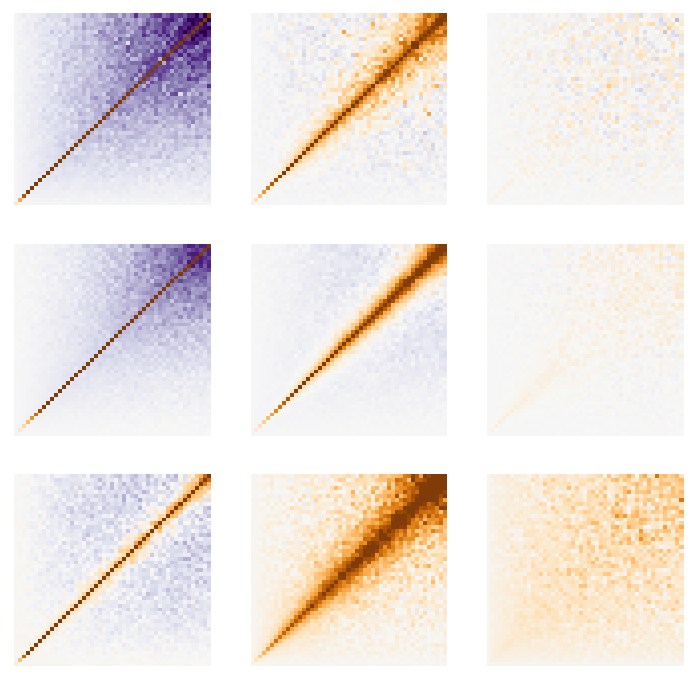

In [209]:
print(r_list)
print(pi_beta[0])
print(pi_beta[2])
print(pi_exp[2]*r_list[:-3])
print(pi_beta[0]*r_list[:-3])
vmax=1

fig = plt.figure(figsize=(12,12))
ax = plt.subplot(331)
ax.pcolormesh(x, x, PMI_beta[0][0,:,:].T,
    vmin=-vmax, vmax=vmax, cmap='PuOr_r')
ax = plt.subplot(332)
ax.pcolormesh(x, x, PMI_beta[0][4,:,:],
    vmin=-vmax, vmax=vmax, cmap='PuOr_r')
ax = plt.subplot(333)
ax.pcolormesh(x, x, PMI_beta[0][7,:,:],
    vmin=-vmax, vmax=vmax, cmap='PuOr_r')

ax = plt.subplot(334)
ax.pcolormesh(x, x, PMI_exp[2][0,:,:],
    vmin=-vmax, vmax=vmax, cmap='PuOr_r')
ax = plt.subplot(335)
ax.pcolormesh(x, x, PMI_exp[2][4,:,:],
    vmin=-vmax, vmax=vmax, cmap='PuOr_r')
ax = plt.subplot(336)
ax.pcolormesh(x, x, PMI_exp[2][7,:,:],
    vmin=-vmax, vmax=vmax, cmap='PuOr_r')

ax = plt.subplot(337)
ax.pcolormesh(x, x, PMI_beta[2][0,:,:],
    vmin=-vmax, vmax=vmax, cmap='PuOr_r')
ax = plt.subplot(338)
ax.pcolormesh(x, x, PMI_beta[2][4,:,:],
    vmin=-vmax, vmax=vmax, cmap='PuOr_r')
ax = plt.subplot(339)
ax.pcolormesh(x, x, PMI_beta[2][7,:,:],
    vmin=-vmax, vmax=vmax, cmap='PuOr_r')

#ax.set_xscale('log')
#ax.set_yscale('log')
for ax in fig.get_axes():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

(0.09, 110)

/Users/danielrice/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


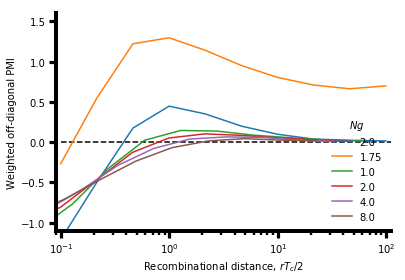

In [200]:
for i,a in enumerate(a_list[:2]):
    plt.semilogx(r_list[:-3]*pi_beta[i]/2, offdiag_beta[i]/pi_beta[i]**2, label=a)

for i,g in enumerate(g_list):
    plt.semilogx(r_list[:-3]*pi_exp[i]/2, offdiag_exp[i]/pi_exp[i]**2, label=g)
plt.legend(title=r'$Ng$', loc='lower right')
plt.hlines(0, r_list[1], r_list[-3], linestyle='dashed')
plt.ylabel('Weighted off-diagonal PMI')
plt.xlabel('Recombinational distance, $rT_c/2$')
plt.ylim([-1.1, 1.6])
plt.xlim([0.09,110])

(-0.1, 1.1)

/Users/danielrice/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


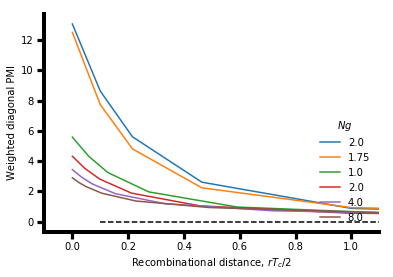

In [201]:
for i,a in enumerate(a_list[:2]):
    plt.plot(r_list[:-3], diag_beta[i]/pi_beta[i]**2, label=a)

for i,g in enumerate(g_list):
    plt.plot(r_list[:-3]*pi_exp[i]/2, diag_exp[i]/pi_exp[i]**2, label=g)
plt.legend(title=r'$Ng$', loc='lower right')
plt.hlines(0, r_list[1], r_list[-3], linestyle='dashed')
plt.ylabel('Weighted diagonal PMI')
plt.xlabel('Recombinational distance, $rT_c/2$')
#plt.ylim([-1.1, 1.6])
plt.xlim([-.1,1.1])

(-1.6, 0.6)

/Users/danielrice/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


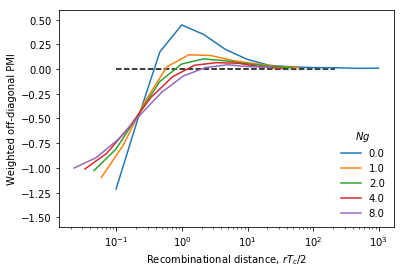

In [50]:
plt.semilogx(r_list*pi_kingman/2, offdiag_kingman/pi_kingman**2, label='0.0')
for i,g in enumerate(g_list):
    plt.semilogx(r_list[:-3]*pi_exp[i]/2, offdiag_exp[i]/pi_exp[i]**2, label=g)
plt.legend(title=r'$Ng$', loc='lower right')
plt.hlines(0, r_list[1], r_list[-3], linestyle='dashed')
plt.ylabel('Weighted off-diagonal PMI')
plt.xlabel('Recombinational distance, $rT_c/2$')
plt.ylim([-1.6, 0.6])

(0.5, 500)

/Users/danielrice/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


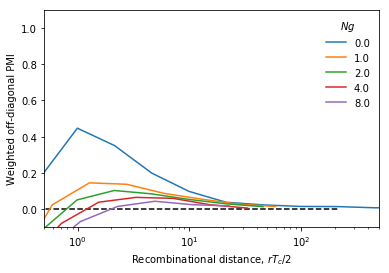

In [86]:
plt.semilogx(r_list*pi_kingman/2, offdiag_kingman/pi_kingman**2, label='0.0')
for i,g in enumerate(g_list):
    plt.semilogx(r_list[:-3]*pi_exp[i]/2, offdiag_exp[i]/pi_exp[i]**2, label=g)
plt.legend(title=r'$Ng$', loc='upper right')
plt.hlines(0, r_list[1], r_list[-3], linestyle='dashed')
plt.ylabel('Weighted off-diagonal PMI')
plt.xlabel('Recombinational distance, $rT_c/2$')
plt.ylim([-0.1,1.1])
plt.xlim([0.5,500])

## Piecewise-constant growth

In [52]:
t_list = [0.01, 0.1, 1.0]
s_list = [0.01, 0.05, 0.1]

mSFS_pwc = []
jSFS_pwc = []
pi_pwc = []
PMI_pwc = []
diag_pwc = []
offdiag_pwc = []
for t in t_list:
    for s in s_list:
        file_list = [data_dir + 'jsfs_T-{}_S-{}_r-{}.txt'.format(t,s,r) for r in r_list[:-3]]
        mSFS, jSFS = import_sfs(file_list, n_samples)
        pi = np.dot(mSFS, pi_weight)
        PMI = pmi(mSFS, jSFS)
        wPMI = PMI * jSFS
        diag = np.sum(np.diagonal(wPMI, axis1=1, axis2=2), axis=1)
        offdiag = np.sum(wPMI, axis=(1,2)) - diag

        mSFS_pwc.append(mSFS)
        jSFS_pwc.append(jSFS)
        pi_pwc.append(pi)
        PMI_pwc.append(PMI)
        diag_pwc.append(diag)
        offdiag_pwc.append(offdiag)

/Users/danielrice/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


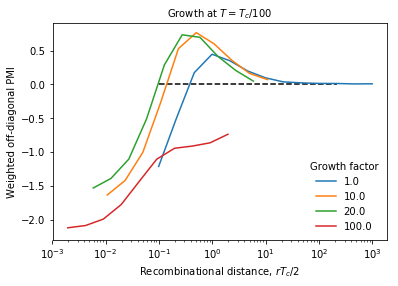

In [76]:
plt.semilogx(r_list*pi_kingman/2, offdiag_kingman/pi_kingman**2, label='1.0')
for i in range(3)[::-1]:
    plt.semilogx(r_list[:-3]*pi_pwc[i]/2, offdiag_pwc[i]/pi_pwc[i]**2, label=1.0/s_list[i])
plt.legend(title='Growth factor', loc='lower right')
plt.hlines(0, r_list[1], r_list[-3], linestyle='dashed')
plt.ylabel('Weighted off-diagonal PMI')
plt.xlabel('Recombinational distance, $rT_c/2$')
plt.title(r'Growth at $T=T_c/100$')
#plt.ylim([-1.6, 0.6])

/Users/danielrice/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


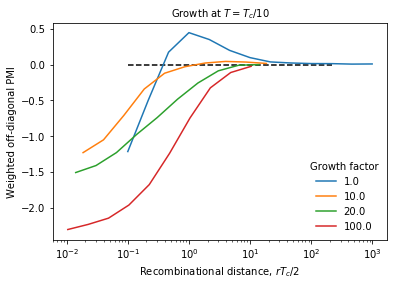

In [84]:
plt.semilogx(r_list*pi_kingman/2, offdiag_kingman/pi_kingman**2, label='1.0')
for i in range(3,6)[::-1]:
    plt.semilogx(r_list[:-3]*pi_pwc[i]/2, offdiag_pwc[i]/pi_pwc[i]**2, label=1.0/s_list[i%3])
plt.legend(title='Growth factor', loc='lower right')
plt.hlines(0, r_list[1], r_list[-3], linestyle='dashed')
plt.ylabel('Weighted off-diagonal PMI')
plt.xlabel('Recombinational distance, $rT_c/2$')
plt.title(r'Growth at $T=T_c/10$')
#plt.ylim([-1.6, 0.6])

/Users/danielrice/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


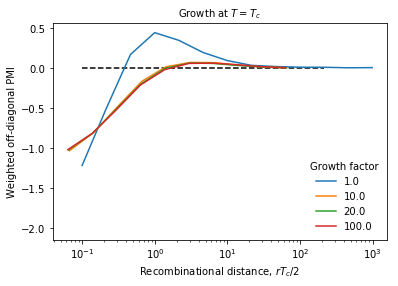

In [72]:
plt.semilogx(r_list*pi_kingman/2, offdiag_kingman/pi_kingman**2, label='1.0')
for i in range(6,9)[::-1]:
    plt.semilogx(r_list[:-3]*pi_pwc[i]/2, offdiag_pwc[i]/pi_pwc[i]**2, label=1.0/s_list[i%3])
plt.legend(title='Growth factor', loc='lower right')
plt.hlines(0, r_list[1], r_list[-3], linestyle='dashed')
plt.ylabel('Weighted off-diagonal PMI')
plt.xlabel('Recombinational distance, $rT_c/2$')
plt.title(r'Growth at $T=T_c$')
#plt.ylim([-1.6, 0.6])

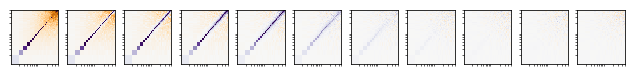

In [79]:
fig = plt.figure(figsize=(11, 1))
for i_r, r in enumerate(r_list[:-3]):
    ax = fig.add_subplot(1, len(r_list)-3, i_r + 1)
    ax.pcolormesh(x, x, PMI_kingman[i_r,:,:],
        vmin=-1, vmax=1, cmap='PuOr')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xticks([])
    ax.set_yticks([])

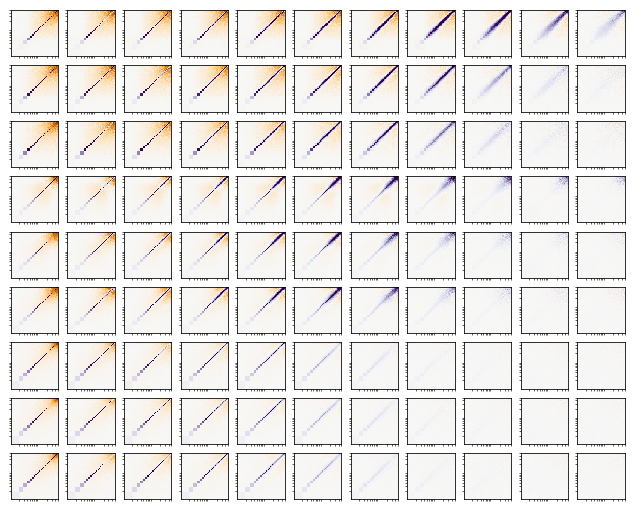

In [70]:
fig = plt.figure(figsize=(11, 9))
for i in range(9):
    for i_r, r in enumerate(r_list[:-3]):
        ax = fig.add_subplot(9, len(r_list)-3, i*(len(r_list)-3) + i_r + 1)
        ax.pcolormesh(x, x, PMI_pwc[i][i_r,:,:],
            vmin=-1, vmax=1, cmap='PuOr')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xticks([])
        ax.set_yticks([])

In [71]:
print([p[0] for p in pi_pwc])

[0.03931284184468873, 0.11792355886964083, 0.21565632577621646, 0.20633696464528922, 0.27842102432256038, 0.3675321258705444, 1.259288814247983, 1.2872353013709388, 1.3244015727836873]


## Bolthausen-Sznitman Coalescent

In [96]:
sim = 'a-1.01'
mMAF = np.zeros((len(r_list), n_samples-1))
jMAF_triu = np.zeros((len(r_list), n_samples*(n_samples-1)//2))
for i, r in enumerate(r_list):
    filecount = 0.0
    for rep in range(10):
        fn = 'jsfs_{}_r-{}_rep-{}.txt'.format(sim, r, rep)
        try:
            datafile = open(data_dir + fn)
        except FileNotFoundError:
            continue
        filecount += 1
        for line in datafile:
            if line.startswith('#'):
                continue
            else:
                mMAF[i,:] += np.array(line.split(), dtype=float)
                jMAF_triu[i,:] += np.array(datafile.readline().split(), dtype=float)
                break
        datafile.close()
    mMAF[i,:] /= filecount
    jMAF_triu[i,:] /= filecount
                
jMAF = np.zeros((len(r_list), n_samples-1, n_samples-1))
for i in range(len(r_list)):
    jMAF[i,:,:][np.triu_indices(n_samples-1)] = jMAF_triu[i,:]
    jMAF[i,:,:][np.diag_indices(n_samples-1)] /= 2
jMAF += np.transpose(jMAF, axes=(0,2,1))

x_fold = x[:n_samples//2]
mMAF_fold = (mMAF + mMAF[:,::-1])[:,:n_samples//2]
mMAF_fold[:,-1] /= 2

jMAF_fold = (jMAF + jMAF[:,::-1,:] + jMAF[:,:,::-1] + jMAF[:,::-1,::-1])[:, :n_samples//2, :n_samples//2]
jMAF_fold[:,-1,:-1] /= 2
jMAF_fold[:,:-1,-1] /= 2
jMAF_fold[:,-1,-1] /= 4


mMAF_sq_fold = mMAF_fold[:,:,None] * mMAF_fold[:,None,:]
ratio_fold = jMAF_fold / mMAF_sq_fold

jMAF_bsc = jMAF_fold
mMAF_bsc = mMAF_fold
pi_bsc = np.dot(mMAF_fold, pi_weight)
#PMI_bsc = jMAF_fold * np.log2(ratio_fold)
PMI_bsc = np.log2(ratio_fold)
wPMI_bsc = jMAF_bsc*PMI_bsc
diag_bsc = np.sum(np.diagonal(wPMI_bsc, axis1=1, axis2=2), axis=1)
offdiag_bsc = np.sum(wPMI_bsc, axis=(1,2)) - diag_bsc

/Users/danielrice/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/Users/danielrice/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


/Users/danielrice/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


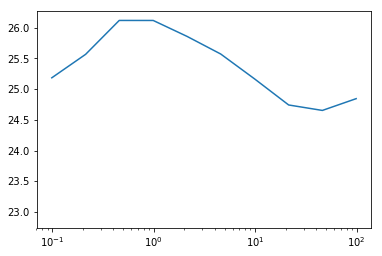

In [98]:
plt.semilogx(r_list*pi_bsc/2, offdiag_bsc/pi_bsc**2)
#print(r_list.shape, pi_bsc.shape, offdiag_bsc.shape)